In [1]:
import yfinance as yf
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib
import talib
import numba
import numpy as np
import lightgbm as lgb
import joblib

from sklearn.ensemble import BaggingRegressor
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import cross_val_score, KFold, TimeSeriesSplit

In [2]:
def plot_corr(series1, series2, title='', xlabel='', ylabel=''):
    corr = series1.corr(series2)
    plt.title(f'{title} (corr={corr:.3f})')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.scatter(series1, series2, alpha=0.5, s=8, label=f'{corr:.3f}')
    plt.legend()

#richmansan 参考  https://github.com/richmanbtc/mlbot_tutorial

def calc_features(df):
    open = df['Open']
    high = df['High']
    low = df['Low']
    close = df['Close']
    volume = df['Volume']
    
    orig_columns = df.columns

    hilo = (df['High'] + df['Low']) / 2
    # 価格(hilo または close)を引いた後、価格(close)で割ることで標準化
    df['BBANDS_upperband'], df['BBANDS_middleband'], df['BBANDS_lowerband'] = talib.BBANDS(close, timeperiod=5, nbdevup=2, nbdevdn=2, matype=0) #ボリンジャーバンド
    df['BBANDS_upperband'] = (df['BBANDS_upperband'] - hilo) / close
    df['BBANDS_middleband'] = (df['BBANDS_middleband'] - hilo) / close
    df['BBANDS_lowerband'] = (df['BBANDS_lowerband'] - hilo) / close

    df['DEMA'] = (talib.DEMA(close, timeperiod=30) - hilo) / close                                   #二重指数移動平均 移動平均をさらに平滑化　EMAよりラグが少ない指標
    df['EMA'] = (talib.EMA(close, timeperiod=30) - hilo) / close                                     #指数移動平均 新しいデータ (直近の価格) により大きなウェイトを与える
    df['HT_TRENDLINE'] = (talib.HT_TRENDLINE(close) - hilo) / close                                  #ヒルベルト変換によるトレンドライン トレンドの変化をとらえる　周期性を考慮
    df['KAMA'] = (talib.KAMA(close, timeperiod=30) - hilo) / close                                   #カフマン適応移動平均 価格の変動率 (ノイズ対トレンド) に適応する移動平均
    df['MA'] = (talib.MA(close, timeperiod=30, matype=0) - hilo) / close                             #ただの移動平均 
    df['MIDPOINT'] = (talib.MIDPOINT(close, timeperiod=14) - hilo) / close                           #中央値
    df['SMA'] = (talib.SMA(close, timeperiod=30) - hilo) / close                                     #単純移動平均
    df['T3'] = (talib.T3(close, timeperiod=5, vfactor=0) - hilo) / close                             #T3移動平均 滑らかでノイズの少ない
    df['TEMA'] = (talib.TEMA(close, timeperiod=30) - hilo) / close                                   #三重指数移動平均 遅れ (ラグ) を最小限に抑える
    df['TRIMA'] = (talib.TRIMA(close, timeperiod=30) - hilo) / close                                 #三角移動平均 ノイズを軽減する移動平均の一種
    df['WMA'] = (talib.WMA(close, timeperiod=30) - hilo) / close                                     #加重移動平均 最新のデータに加重をかけ感度を高める

    df['LINEARREG'] = (talib.LINEARREG(close, timeperiod=14) - close) / close                        #線形回帰値
    df['LINEARREG_INTERCEPT'] = (talib.LINEARREG_INTERCEPT(close, timeperiod=14) - close) / close    #線形回帰の切片


    # 価格(close)で割ることで標準化
    df['AD'] = talib.AD(high, low, close, volume) / close                                            # AD (Accumulation/Distribution ライン): 高値、安値、終値、出来高を使用して累積的な買い圧力と売り圧力を計算
    df['ADOSC'] = talib.ADOSC(high, low, close, volume, fastperiod=3, slowperiod=10) / close         #ADOSC (Accumulation/Distribution オシレーター): 累積的な買い圧力と売り圧力の変化速度を計算
    df['APO'] = talib.APO(close, fastperiod=12, slowperiod=26, matype=0) / close                     # APO (Absolute Price Oscillator): 高速 EMA と低速 EMA の差分を計算
    df['HT_PHASOR_inphase'], df['HT_PHASOR_quadrature'] = talib.HT_PHASOR(close)                     # HT_PHASOR (ヒルベルト変換によるフェーザー): トレンドやサイクルを把握するための指標
    df['HT_PHASOR_inphase'] /= close  # in-phase を標準化
    df['HT_PHASOR_quadrature'] /= close  # quadrature を標準化

    df['LINEARREG_SLOPE'] = talib.LINEARREG_SLOPE(close, timeperiod=14) / close                      # LINEARREG_SLOPE (線形回帰の傾き): 過去のデータに基づくトレンドの傾きを計算

    
    df['MACD_macd'], df['MACD_macdsignal'], df['MACD_macdhist'] = talib.MACD(close, fastperiod=12, slowperiod=26, signalperiod=9) # MACD (移動平均収束拡散法): トレンドの強さや方向性を把握する指標
    df['MACD_macd'] /= close                                                                        # MACD ラインを標準化
    df['MACD_macdsignal'] /= close                                                                  # シグナルラインを標準化
    df['MACD_macdhist'] /= close                                                                    # MACD ヒストグラムを標準化

    df['MINUS_DM'] = talib.MINUS_DM(high, low, timeperiod=14) / close                               # MINUS_DM (Negative Directional Movement): 買い圧力の低下を計算
    df['MOM'] = talib.MOM(close, timeperiod=10) / close                                             # MOM (Momentum): 現在の価格と指定期間前の価格との差分
    df['OBV'] = talib.OBV(close, volume) / close                                                    # OBV (On-Balance Volume): 出来高を使用して買いと売りの勢力を評価
    df['PLUS_DM'] = talib.PLUS_DM(high, low, timeperiod=14) / close                                 # PLUS_DM (Positive Directional Movement): 買い圧力の増加を計算
    df['STDDEV'] = talib.STDDEV(close, timeperiod=5, nbdev=1) / close                               # STDDEV (Standard Deviation): 指定期間の価格変動の標準偏差
    df['TRANGE'] = talib.TRANGE(high, low, close) / close                                           # TRANGE (True Range): 価格変動幅を評価する指標



    
    df['ADX'] = talib.ADX(high, low, close, timeperiod=14)                                          # ADX (Average Directional Movement Index): トレンドの強さを評価する指標
    df['ADXR'] = talib.ADXR(high, low, close, timeperiod=14)                                        # ADXR (Average Directional Movement Rating): ADX の動きを平滑化した指標
    df['AROON_aroondown'], df['AROON_aroonup'] = talib.AROON(high, low, timeperiod=14)              # AROON (アローンインジケーター): トレンドの強さと方向を評価する
    df['AROONOSC'] = talib.AROONOSC(high, low, timeperiod=14)                                       # AROONOSC (アローンオシレーター): Aroon Up と Aroon Down の差分を計算
    df['BOP'] = talib.BOP(open, high, low, close)                                                   # BOP (Balance of Power): 買い手と売り手の勢力バランスを評価
    df['CCI'] = talib.CCI(high, low, close, timeperiod=14)                                          # CCI (Commodity Channel Index): 現在の価格と過去の平均価格を比較

    
    df['DX'] = talib.DX(high, low, close, timeperiod=14)                                            # DX (Directional Movement Index): トレンドの方向性の強さを計算
    df['MFI'] = talib.MFI(high, low, close, volume, timeperiod=14)                                  # MFI (Money Flow Index): 価格と出来高を組み合わせて買われ過ぎ・売られ過ぎを評価
    df['MINUS_DI'] = talib.MINUS_DI(high, low, close, timeperiod=14)                                # MINUS_DI (Negative Directional Indicator): 売り圧力の強さを評価
    df['PLUS_DI'] = talib.PLUS_DI(high, low, close, timeperiod=14)                                  # PLUS_DI (Positive Directional Indicator): 買い圧力の強さを評価
    df['RSI'] = talib.RSI(close, timeperiod=14)                                                     # RSI (Relative Strength Index): 買われ過ぎや売られ過ぎを判断
    df['STOCH_slowk'], df['STOCH_slowd'] = talib.STOCH(
        high, low, close, fastk_period=5, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0
    )                                                                                               # STOCH (Stochastic Oscillator): 現在の価格が過去のレンジ内のどこに位置するかを評価
    df['STOCHF_fastk'], df['STOCHF_fastd'] = talib.STOCHF(
        high, low, close, fastk_period=5, fastd_period=3, fastd_matype=0
    )                                                                                               # STOCHF (Fast Stochastic Oscillator): より速い動きに対応するストキャスティクス
    df['STOCHRSI_fastk'], df['STOCHRSI_fastd'] = talib.STOCHRSI(
        close, timeperiod=14, fastk_period=5, fastd_period=3, fastd_matype=0
    )                                                                                               # STOCHRSI (Stochastic RSI): RSI を基にしたストキャスティクス
    df['TRIX'] = talib.TRIX(close, timeperiod=30)                                                   #TRIX (Triple Exponential Moving Average): トレンドの強さを評価
    df['ULTOSC'] = talib.ULTOSC(high, low, close, timeperiod1=7, timeperiod2=14, timeperiod3=28)    # ULTOSC (Ultimate Oscillator): 複数期間を組み合わせたオシレーター
    df['WILLR'] = talib.WILLR(high, low, close, timeperiod=14)                                      # WILLR (Williams %R): 買われ過ぎ・売られ過ぎを評価
    df['ATR'] = talib.ATR(high, low, close, timeperiod=14)                                          # ATR (Average True Range): 価格変動の平均的な幅を評価
    df['NATR'] = talib.NATR(high, low, close, timeperiod=14)                                        # NATR (Normalized Average True Range): ATR を価格で正規化
    df['HT_DCPERIOD'] = talib.HT_DCPERIOD(close)                                                    # HT_DCPERIOD (ヒルベルト変換周期): トレンドの周期を計算
    df['HT_DCPHASE'] = talib.HT_DCPHASE(close)                                                      # HT_DCPHASE (ヒルベルト変換位相): トレンドの位相を計算
    df['HT_SINE_sine'], df['HT_SINE_leadsine'] = talib.HT_SINE(close)                               # HT_SINE (ヒルベルト変換サイン波): サイクル成分を評価
    df['HT_TRENDMODE'] = talib.HT_TRENDMODE(close)                                                  # HT_TRENDMODE (ヒルベルト変換トレンドモード): トレンドモードを検出
    df['BETA'] = talib.BETA(high, low, timeperiod=5)                                                # BETA (Beta): 2つのデータセット間のベータ値を計算
    df['CORREL'] = talib.CORREL(high, low, timeperiod=30)                                           # CORREL (Correlation): 高値と安値の相関係数を計算
    df['LINEARREG_ANGLE'] = talib.LINEARREG_ANGLE(close, timeperiod=14)                             # LINEARREG_ANGLE (線形回帰の角度): トレンドの角度を評価

    return df



In [3]:
target = "4186.T" #東京応化
ohlcv_target =yf.download(target,start="2020-01-01",end="2024-12-31")
ohlcv_target['fee'] = 0.0
ohlcv_target

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume,fee
Ticker,4186.T,4186.T,4186.T,4186.T,4186.T,
Date,,,,,,
2020-01-06,1266.765137,1274.305442,1250.176509,1253.192653,475500,0.0
2020-01-07,1295.418213,1296.926340,1268.273244,1269.781371,338400,0.0
2020-01-08,1277.321655,1286.369979,1260.733136,1280.337800,401400,0.0
2020-01-09,1298.434204,1319.546992,1295.418060,1313.514704,345000,0.0
2020-01-10,1302.958496,1302.958496,1290.894029,1290.894029,268500,0.0
...,...,...,...,...,...,...
2024-12-24,3465.173340,3552.447311,3457.239343,3547.488562,366700,0.0
2024-12-25,3457.239258,3475.090751,3402.693027,3471.123753,403400,0.0


In [4]:
ohlcv_target.isnull().sum()

Price   Ticker
Close   4186.T    0
High    4186.T    0
Low     4186.T    0
Open    4186.T    0
Volume  4186.T    0
fee               0
dtype: int64

In [5]:
ohlcv_target_drop = ohlcv_target.copy()
ohlcv_target_drop.columns = ohlcv_target_drop.columns.droplevel(1)
ohlcv_target_drop

Price,Close,High,Low,Open,Volume,fee
Date,,,,,,
2020-01-06,1266.765137,1274.305442,1250.176509,1253.192653,475500,0.0
2020-01-07,1295.418213,1296.926340,1268.273244,1269.781371,338400,0.0
2020-01-08,1277.321655,1286.369979,1260.733136,1280.337800,401400,0.0
2020-01-09,1298.434204,1319.546992,1295.418060,1313.514704,345000,0.0
2020-01-10,1302.958496,1302.958496,1290.894029,1290.894029,268500,0.0
...,...,...,...,...,...,...
2024-12-24,3465.173340,3552.447311,3457.239343,3547.488562,366700,0.0
2024-12-25,3457.239258,3475.090751,3402.693027,3471.123753,403400,0.0
2024-12-26,3486.000000,3496.909246,3444.346515,3471.123755,453900,0.0


In [7]:
talib_df = calc_features(ohlcv_target_drop)
display(talib_df)
talib_df.to_pickle('df_features.pkl')

Price,Close,High,Low,Open,Volume,fee,BBANDS_upperband,BBANDS_middleband,BBANDS_lowerband,DEMA,...,ATR,NATR,HT_DCPERIOD,HT_DCPHASE,HT_SINE_sine,HT_SINE_leadsine,HT_TRENDMODE,BETA,CORREL,LINEARREG_ANGLE
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-06,1266.765137,1274.305442,1250.176509,1253.192653,475500,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN
2020-01-07,1295.418213,1296.926340,1268.273244,1269.781371,338400,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN
2020-01-08,1277.321655,1286.369979,1260.733136,1280.337800,401400,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN
2020-01-09,1298.434204,1319.546992,1295.418060,1313.514704,345000,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN
2020-01-10,1302.958496,1302.958496,1290.894029,1290.894029,268500,0.0,0.014472,-0.006713,-0.027898,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-24,3465.173340,3552.447311,3457.239343,3547.488562,366700,0.0,0.007129,-0.007212,-0.021554,-0.006226,...,85.206887,2.458950,16.084036,31.748624,0.526194,0.973374,0,1.166217,0.950701,-74.371204
2024-12-25,3457.239258,3475.090751,3402.693027,3471.123753,403400,0.0,0.025967,0.010643,-0.004682,0.011587,...,84.291947,2.438129,16.075518,42.239951,0.672237,0.998840,0,0.902008,0.928212,-69.741155
2024-12-26,3486.000000,3496.909246,3444.346515,3471.123755,453900,0.0,0.017218,0.003272,-0.010675,0.002307,...,82.025574,2.353000,16.098064,53.681465,0.805737,0.988543,1,0.829130,0.892450,-66.297116


In [8]:
talib_df.isnull().sum()

Price
Close                0
High                 0
Low                  0
Open                 0
Volume               0
                    ..
HT_SINE_leadsine    63
HT_TRENDMODE         0
BETA                 5
CORREL              29
LINEARREG_ANGLE     13
Length: 68, dtype: int64

In [9]:
features = sorted([
    'ADX',
    'ADXR',
    'APO',
    'AROON_aroondown',
    'AROON_aroonup',
    'AROONOSC',
    'CCI',
    'DX',
    'MACD_macd',
    'MACD_macdsignal',
    'MACD_macdhist',
    'MFI',
#     'MINUS_DI',
#     'MINUS_DM',
    'MOM',
#     'PLUS_DI',
#     'PLUS_DM',
    'RSI',
    'STOCH_slowk',
    'STOCH_slowd',
    'STOCHF_fastk',
#     'STOCHRSI_fastd',
    'ULTOSC',
    'WILLR',
#     'ADOSC',
#     'NATR',
    'HT_DCPERIOD',
    'HT_DCPHASE',
    'HT_PHASOR_inphase',
    'HT_PHASOR_quadrature',
    'HT_TRENDMODE',
    'BETA',
    'LINEARREG',
    'LINEARREG_ANGLE',
    'LINEARREG_INTERCEPT',
    'LINEARREG_SLOPE',
    'STDDEV',
    'BBANDS_upperband',
    'BBANDS_middleband',
    'BBANDS_lowerband',
    'DEMA',
    'EMA',
    'HT_TRENDLINE',
    'KAMA',
    'MA',
    'MIDPOINT',
    'T3',
    'TEMA',
    'TRIMA',
    'WMA',
])

print(features)

['ADX', 'ADXR', 'APO', 'AROONOSC', 'AROON_aroondown', 'AROON_aroonup', 'BBANDS_lowerband', 'BBANDS_middleband', 'BBANDS_upperband', 'BETA', 'CCI', 'DEMA', 'DX', 'EMA', 'HT_DCPERIOD', 'HT_DCPHASE', 'HT_PHASOR_inphase', 'HT_PHASOR_quadrature', 'HT_TRENDLINE', 'HT_TRENDMODE', 'KAMA', 'LINEARREG', 'LINEARREG_ANGLE', 'LINEARREG_INTERCEPT', 'LINEARREG_SLOPE', 'MA', 'MACD_macd', 'MACD_macdhist', 'MACD_macdsignal', 'MFI', 'MIDPOINT', 'MOM', 'RSI', 'STDDEV', 'STOCHF_fastk', 'STOCH_slowd', 'STOCH_slowk', 'T3', 'TEMA', 'TRIMA', 'ULTOSC', 'WILLR', 'WMA']


In [ ]:
@numba.njit
def calc_force_entry_price(entry_price=None, lo=None, pips=None):
    y = entry_price.copy()
    y[:] = np.nan
    force_entry_time = entry_price.copy()
    force_entry_time[:] = np.nan
    for i in range(entry_price.size):
        for j in range(i + 1, entry_price.size):
            if round(lo[j] / pips) < round(entry_price[j - 1] / pips):
                y[i] = entry_price[j - 1]
                force_entry_time[i] = j - i
                break
    return y, force_entry_time

df = pd.read_pickle('df_features.pkl')

# 呼び値 (取引所、取引ペアごとに異なるので、適切に設定してください)
pips = 1

# ATRで指値距離を計算します
limit_price_dist = df['ATR'] * 0.5
limit_price_dist = np.maximum(1, (limit_price_dist / pips).round().fillna(1)) * pips

# 終値から両側にlimit_price_distだけ離れたところに、買い指値と売り指値を出します
df['buy_price'] = df['cl'] - limit_price_dist
df['sell_price'] = df['cl'] + limit_price_dist

# Force Entry Priceの計算
df['buy_fep'], df['buy_fet'] = calc_force_entry_price(
    entry_price=df['buy_price'].values,
    lo=df['lo'].values,
    pips=pips,
)

# calc_force_entry_priceは入力と出力をマイナスにすれば売りに使えます
df['sell_fep'], df['sell_fet'] = calc_force_entry_price(
    entry_price=-df['sell_price'].values,
    lo=-df['hi'].values, # 売りのときは高値
    pips=pips,
)
df['sell_fep'] *= -1

horizon = 1 # エントリーしてからエグジットを始めるまでの待ち時間 (1以上である必要がある)
fee = df['fee'] # maker手数料

# 指値が約定したかどうか (0, 1)
df['buy_executed'] = ((df['buy_price'] / pips).round() > (df['lo'].shift(-1) / pips).round()).astype('float64')
df['sell_executed'] = ((df['sell_price'] / pips).round() < (df['hi'].shift(-1) / pips).round()).astype('float64')

# yを計算
df['y_buy'] = np.where(
    df['buy_executed'],
    df['sell_fep'].shift(-horizon) / df['buy_price'] - 1 - 2 * fee,
    0
)
df['y_sell'] = np.where(
    df['sell_executed'],
    -(df['buy_fep'].shift(-horizon) / df['sell_price'] - 1) - 2 * fee,
    0
)

# バックテストで利用する取引コストを計算
df['buy_cost'] = np.where(
    df['buy_executed'],
    df['buy_price'] / df['cl'] - 1 + fee,
    0
)
df['sell_cost'] = np.where(
    df['sell_executed'],
    -(df['sell_price'] / df['cl'] - 1) + fee,
    0
)

print('約定確率を可視化。時期によって約定確率が大きく変わると良くない。')
df['buy_executed'].rolling(1000).mean().plot(label='買い')
df['sell_executed'].rolling(1000).mean().plot(label='売り')
plt.title('約定確率の推移')
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

print('エグジットまでの時間分布を可視化。長すぎるとロングしているだけとかショートしているだけになるので良くない。')
df['buy_fet'].rolling(1000).mean().plot(label='買い')
df['sell_fet'].rolling(1000).mean().plot(label='売り')
plt.title('エグジットまでの平均時間推移')
plt.legend(bbox_to_anchor=(1.2, 1))
plt.show()

df['buy_fet'].hist(alpha=0.3, label='買い')
df['sell_fet'].hist(alpha=0.3, label='売り')
plt.title('エグジットまでの時間分布')
plt.legend(bbox_to_anchor=(1.2, 1))
plt.show()

print('毎時刻、この執行方法でトレードした場合の累積リターン')
df['y_buy'].cumsum().plot(label='買い')
df['y_sell'].cumsum().plot(label='売り')
plt.title('累積リターン')
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

df.to_pickle('df_y.pkl')

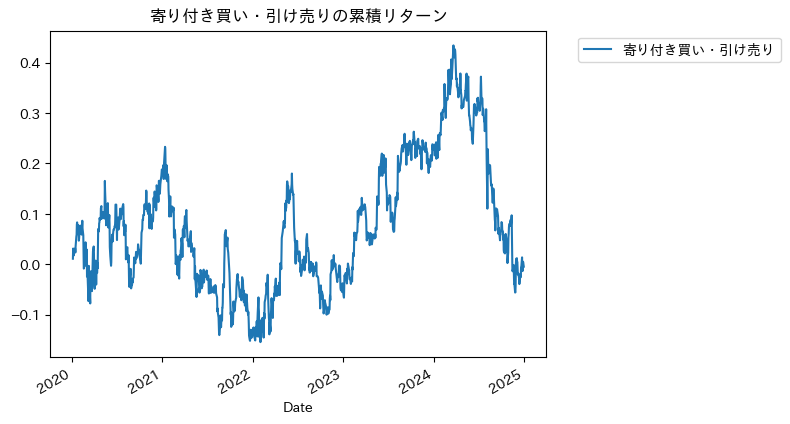

In [12]:
# 取引手数料
fee = df['fee']

# --- 成行取引の処理 ---
# 寄り付きで買い、引けで売る

df['open_buy_price'] = df['Open']  # 寄り付きの価格

df['close_sell_price'] = df['Close']  # 引けの価格

# 成行なので必ず約定
df['open_buy_executed'] = 1.0  # すべて約定
df['close_sell_executed'] = 1.0  # すべて約定

# 成行取引のリターン計算 (手数料込み)
df['y_open_close'] = df['Close'] / df['Open'] - 1 - 2 * fee



df['y_open_close'].cumsum().plot(label='寄り付き買い・引け売り')
plt.title('寄り付き買い・引け売りの累積リターン')
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

# データを保存
df.to_pickle('df_open_close.pkl')

In [15]:
df

Price,Close,High,Low,Open,Volume,fee,BBANDS_upperband,BBANDS_middleband,BBANDS_lowerband,DEMA,...,y_sell,buy_cost,sell_cost,open_buy_price,close_sell_price,open_buy_executed,close_sell_executed,y_open_close,y_pred_buy,y_pred_sell
Date,,,,,,,,,,,,,,,,,,,,,
2020-05-19,1465.828369,1529.166632,1462.812225,1506.545824,1439700,0.0,0.103682,0.008230,-0.087221,-0.042404,...,-0.042530,0.000000,-0.021148,1506.545824,1465.828369,1.0,1.0,-0.027027,0.003461,-0.022901
2020-05-20,1511.070190,1538.215164,1471.860747,1477.893037,1010400,0.0,0.078386,0.016367,-0.045652,-0.037369,...,0.000000,0.000000,0.000000,1477.893037,1511.070190,1.0,1.0,0.022449,0.000141,-0.014639
2020-05-21,1511.070190,1535.199019,1503.529883,1523.134660,427200,0.0,0.042208,-0.003892,-0.049993,-0.038143,...,-0.012601,0.000000,-0.019853,1523.134660,1511.070190,1.0,1.0,-0.007921,-0.007688,-0.004187
2020-05-22,1535.198853,1547.263321,1491.465363,1514.086171,788700,0.0,0.020296,-0.008939,-0.038175,-0.027947,...,0.000000,0.000000,0.000000,1514.086171,1535.198853,1.0,1.0,0.013944,-0.012297,-0.007936
2020-05-25,1550.279419,1556.311598,1529.166628,1556.311598,352200,0.0,0.018853,-0.018093,-0.055040,-0.033063,...,0.011898,0.000000,-0.018706,1556.311598,1550.279419,1.0,1.0,-0.003876,-0.029198,-0.004806
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-18,3478.065918,3515.752404,3463.189674,3471.123671,394200,0.0,0.005754,-0.005275,-0.016304,0.000310,...,0.000000,-0.012651,0.000000,3471.123671,3478.065918,1.0,1.0,0.002000,-0.000762,-0.005115
2024-12-19,3454.263916,3459.222664,3391.783690,3391.783690,470900,0.0,0.022233,0.011427,0.000621,0.017229,...,0.003888,0.000000,-0.012738,3391.783690,3454.263916,1.0,1.0,0.018421,-0.009292,0.004634
2024-12-20,3475.090820,3500.876312,3455.255827,3473.107321,567300,0.0,0.004773,-0.001427,-0.007627,0.001319,...,0.009220,0.000000,-0.012086,3473.107321,3475.090820,1.0,1.0,0.000571,-0.001998,-0.009307


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002305 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10006
[LightGBM] [Info] Number of data points in the train set: 1130, number of used features: 43
[LightGBM] [Info] Start training from score -0.001048
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000584 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10006
[LightGBM] [Info] Number of data points in the train set: 1130, number of used features: 43
[LightGBM] [Info] Start training from score -0.001248
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000330 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10006
[LightGBM] [Info] Number of data points in the train set: 904, number of used features: 43
[LightGBM] [Info] Start tr

/home/k/Investment/project01/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/k/Investment/project01/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/k/Investment/project01/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/k/Investment/project01/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/k/Investment/project01/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finit

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000297 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10006
[LightGBM] [Info] Number of data points in the train set: 904, number of used features: 43
[LightGBM] [Info] Start training from score -0.000531
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000291 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10006
[LightGBM] [Info] Number of data points in the train set: 904, number of used features: 43
[LightGBM] [Info] Start training from score -0.001082
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000305 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10006
[LightGBM] [Info] Number of data points in the train set: 904, number of used features: 43
[LightGBM] [Info] Start trai

/home/k/Investment/project01/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/k/Investment/project01/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/k/Investment/project01/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/k/Investment/project01/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/k/Investment/project01/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finit

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000313 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10005
[LightGBM] [Info] Number of data points in the train set: 904, number of used features: 43
[LightGBM] [Info] Start training from score -0.000907
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000312 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10006
[LightGBM] [Info] Number of data points in the train set: 904, number of used features: 43
[LightGBM] [Info] Start training from score -0.000734
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000305 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10006
[LightGBM] [Info] Number of data points in the train set: 904, number of used features: 43
[LightGBM] [Info] Start trai

/home/k/Investment/project01/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/k/Investment/project01/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/k/Investment/project01/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/k/Investment/project01/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/k/Investment/project01/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finit

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000649 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10006
[LightGBM] [Info] Number of data points in the train set: 904, number of used features: 43
[LightGBM] [Info] Start training from score -0.001467
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000568 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10006
[LightGBM] [Info] Number of data points in the train set: 904, number of used features: 43
[LightGBM] [Info] Start training from score -0.001278
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000462 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10005
[LightGBM] [Info] Number of data points in the train set: 904, number of used features: 43
[LightGBM] [Info] Start trai

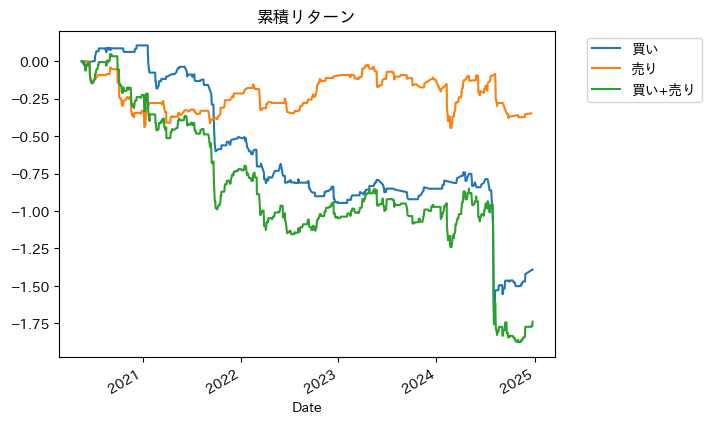

In [13]:
df = pd.read_pickle('df_open_close.pkl')
df = df.dropna()

# モデル (コメントアウトで他モデルも試してみてください)
# model = RidgeCV(alphas=np.logspace(-7, 7, num=20))
model = lgb.LGBMRegressor(n_jobs=-1, random_state=1)

# アンサンブル (コメントアウトを外して性能を比較してみてください)
# model = BaggingRegressor(model, random_state=1, n_jobs=1)

# 本番用モデルの学習 (このチュートリアルでは使わない)
# 実稼働する用のモデルはデータ全体で学習させると良い
model.fit(df[features], df['y_buy'])
joblib.dump(model, 'model_y_buy.xz', compress=True) 
model.fit(df[features], df['y_sell'])
joblib.dump(model, 'model_y_sell.xz', compress=True)

# 通常のCV
cv_indicies = list(KFold().split(df))
# ウォークフォワード法
# cv_indicies = list(TimeSeriesSplit().split(df))

# OOS予測値を計算
def my_cross_val_predict(estimator, X, y=None, cv=None):
    y_pred = y.copy()
    y_pred[:] = np.nan
    for train_idx, val_idx in cv:
        estimator.fit(X[train_idx], y[train_idx])
        y_pred[val_idx] = estimator.predict(X[val_idx])
    return y_pred

df['y_pred_buy'] = my_cross_val_predict(model, df[features].values, df['y_buy'].values, cv=cv_indicies)
df['y_pred_sell'] = my_cross_val_predict(model, df[features].values, df['y_sell'].values, cv=cv_indicies)

# 予測値が無い(nan)行をドロップ
df = df.dropna()

print('毎時刻、y_predがプラスのときだけトレードした場合の累積リターン')
df[df['y_pred_buy'] > 0]['y_buy'].cumsum().plot(label='買い')
df[df['y_pred_sell'] > 0]['y_sell'].cumsum().plot(label='売り')
(df['y_buy'] * (df['y_pred_buy'] > 0) + df['y_sell'] * (df['y_pred_sell'] > 0)).cumsum().plot(label='買い+売り')
plt.title('累積リターン')
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

df.to_pickle('df_fit.pkl')